# Image Classification

## cs231n lecture 2

### [assignment](https://cs231n.github.io/assignments2020/assignment1/#goals)

## k-Nearest Neighbor

In [1]:
# library setup
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline

# set plt default params
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# more magics! see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)


# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


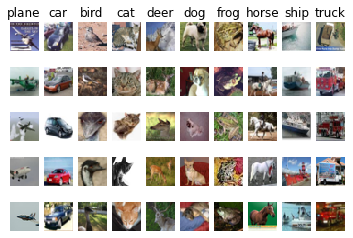

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace = False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8')) 
        # uint8 -> 0 포함 양수값만 0~255(2^8)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training)) # masking image with num_training list range
X_train = X_train[mask]
y_train = y_train[mask] # subsampling train data with upper defined range

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [8]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [10]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


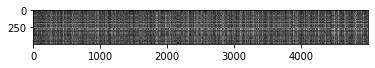

In [13]:
# We can visualize the distance matrix: each row is a single test example
# and its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *test image is highly different with
train image (big distance value), train image is highly different with test image*



In [51]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k = 1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [52]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$
